In [1]:
# Monta o drive para ler os dados salvos no mesmo
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip3 install pickle5
import pickle5 as pickle

In [3]:
# Carregar as bibliotecas
import os
#import pickle
import cv2
import nibabel as nib
import numpy as np

from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

In [4]:
def normImage(image):
    image-=np.min(image)
    if np.max(image)!=0:
      image = (image/np.max(image))
    return image

In [5]:
# Carregar o modelo
unet = load_model(os.path.join('/content/gdrive/MyDrive/dados','DNN_covid_masks.hdf5'))

In [6]:
#listar os dados
ct0_path = "/content/gdrive/MyDrive/COVID19_1110/studies/CT-0"
ct1_path = "/content/gdrive/MyDrive/COVID19_1110/studies/CT-1"
ct2_path = "/content/gdrive/MyDrive/COVID19_1110/studies/CT-2"

#
masks_path = "/content/gdrive/MyDrive/COVID19_1110/masks"

mask_files = os.listdir(masks_path)
mask_files.sort()
#
ct0_files = os.listdir(ct0_path)
ct0_files.sort()
ct1_files = os.listdir(ct1_path)
ct1_files.sort()
ct2_files = os.listdir(ct2_path)
ct2_files.sort()

In [7]:
#Formatar os dados
train_data = []
test_data = []
train_labels = []
test_labels = []

for f_idx,f in enumerate(mask_files): 
    if f_idx<40: #pular as imagens usadas no treino
       continue
    print(f)
    full_mask_path = os.path.join(masks_path, f)
    
    mask = nib.load(full_mask_path)
    n_masks = mask.dataobj.shape[-1]
    
    image_name_parts = f.split('_mask')
    image_name = image_name_parts[0]+image_name_parts[-1]
    if image_name in ct1_files:
        full_image_path = os.path.join(ct1_path, image_name) 
        ct_image = nib.load(full_image_path)
    elif image_name in ct2_files:
        full_image_path = os.path.join(ct2_path, image_name)
        ct_image = nib.load(full_image_path)
    else:
        print("vish")
        print(image_name)
        break
    
    
    id_m = [] # armazena os indices do arquivo que contém marcações
    
    ht_image_path = os.path.join(ct0_path, ct0_files[f_idx]) 
    cth_image = nib.load(ht_image_path)
      
    for m_slice in range(n_masks):
        norm_cvd_img = normImage(cv2.resize(ct_image.dataobj[:,:,m_slice],
                                           (128,128),
                                           cv2.INTER_LINEAR))    
        
        norm_mask_img = normImage(cv2.resize(mask.dataobj[:,:,m_slice],
                                           (128,128),
                                           cv2.INTER_LINEAR))
        norm_mask_img[norm_mask_img>0] = 1
        norm_mask_img[norm_mask_img<=0] = 0

        
        if f_idx<40:
            train_data.append(norm_cvd_img.copy())
            train_labels.append( norm_mask_img.copy())
        else:
            test_data.append(norm_cvd_img.copy())
            test_labels.append(norm_mask_img.copy())

study_0295_mask.nii.gz
study_0296_mask.nii.gz
study_0297_mask.nii.gz
study_0298_mask.nii.gz
study_0299_mask.nii.gz
study_0300_mask.nii.gz
study_0301_mask.nii.gz
study_0302_mask.nii.gz
study_0303_mask.nii.gz
study_0304_mask.nii.gz


In [8]:
#Remodelar os dados  
test_data=np.array(test_data)
test_data = test_data.reshape((test_data.shape[0],test_data.shape[1],test_data.shape[2],1))
test_labels=np.array(test_labels)
test_labels = test_labels.reshape((test_labels.shape[0],test_labels.shape[1],test_labels.shape[2],1))

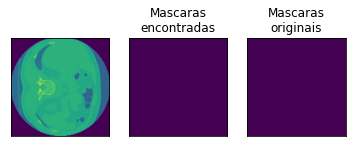

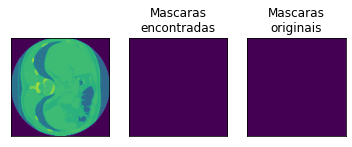

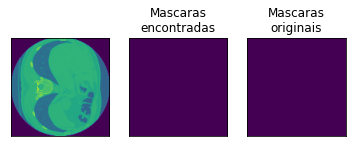

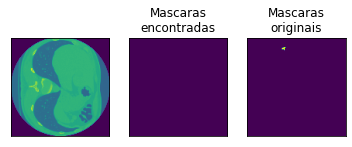

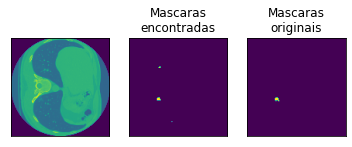

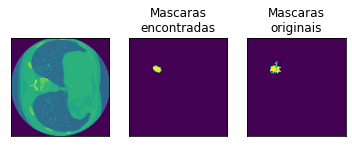

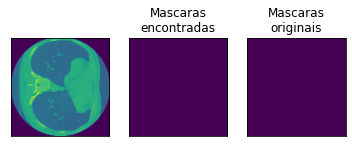

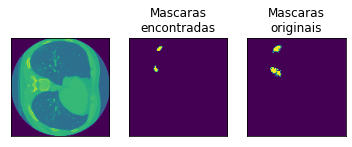

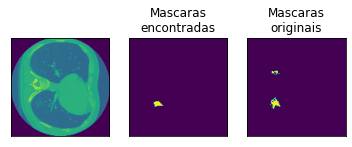

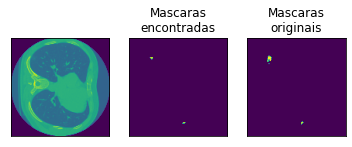

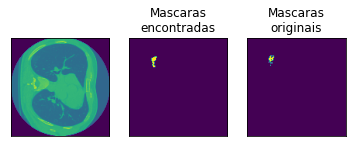

In [9]:
# Classificar os dados de teste
for i in range(1,23,2):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
    ax0.imshow(test_data[i].reshape(128,128))
    ax1.imshow(np.round(unet.predict(test_data[i].reshape(1,128,128,1))).reshape(128,128))
    ax2.imshow(test_labels[i].reshape(128,128))
    
    ax1.set_title("CT")
    ax1.set_title("Mascaras\nencontradas")
    ax2.set_title("Mascaras\noriginais")
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])

In [10]:
#verificar a quantidade de frames que possuem mascaras
is_infected_true = []
is_infected_pred = []
for label,frame in zip(test_labels,test_data):
  pred_mask = unet.predict(frame.reshape(1,128,128,1))
  if np.max(label) > 0:
    is_infected_true.append(1)
  else:
    is_infected_true.append(0)

  pred_mask = np.round(pred_mask)
  if np.max(pred_mask) > 0:
    is_infected_pred.append(1)
  else:
    is_infected_pred.append(0)

is_infected_true = np.array(is_infected_true)
is_infected_pred = np.array(is_infected_pred)

In [11]:
# caucular as métricas
from sklearn import metrics

acc = metrics.accuracy_score(is_infected_true,is_infected_pred)
print("Acurácia:",acc*100,'%')

cm = metrics.confusion_matrix(is_infected_true,is_infected_pred,labels = [0,1])
tn, fp, fn, tp = cm.ravel()
print("Sensitividade:",(tp/(tp+fn))*100,'%')
print("Especificidade",(tn/(tn+fp))*100,'%')

Acurácia: 82.3960880195599 %
Sensitividade: 76.58227848101265 %
Especificidade 86.05577689243027 %
